In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/animesh/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', 
                 names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])

In [5]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,accep
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [10]:
nrows = df.shape[0]

df.safety.value_counts(normalize=True)

low     0.333333
med     0.333333
high    0.333333
Name: safety, dtype: float64

## Create Bootstrap Samples

In [14]:
bootstrap = df.sample(nrows, replace = True) 

bootstrap.safety.value_counts(normalize=True)

med     0.335648
low     0.332176
high    0.332176
Name: safety, dtype: float64

In [16]:
low_perc = []

for i in range(1000):
    bootstrap = df.sample(nrows, replace = True) 
    low_perc.append(bootstrap.safety.value_counts(normalize=True).low)    

0.3327910879629629


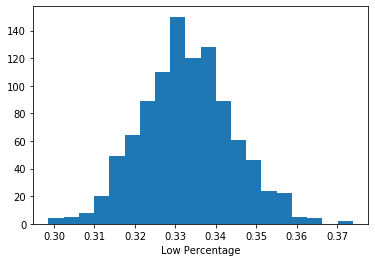

In [17]:
mean_lp = np.mean(low_perc) 
print(mean_lp)
plt.hist(low_perc, bins=20);
plt.xlabel('Low Percentage')
plt.show()

## Bagging

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])
df['accep'] = ~(df['accep']=='unacc') #1 is acceptable, 0 if not acceptable
X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)
y = df['accep']
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.25)

In [29]:
# Decision tree trained on  training set
dtree = DecisionTreeClassifier(max_depth = 5)
dtree.fit(x_train,y_train)

dtree.score(x_test, y_test)

0.8587962962962963

In [30]:
dt = DecisionTreeClassifier(max_depth = 5)
dt.fit(x_train,y_train)

# dtree.score(x_test, y_test)
print(f'Accuracy score of DT on test set (trained using full set): {dt.score(x_test, y_test).round(4)}')

Accuracy score of DT on test set (trained using full set): 0.8588


In [37]:
dt2 = DecisionTreeClassifier(max_depth=5)
#ids are the indices of the bootstrapped sample
ids = x_train.sample(x_train.shape[0], replace=True, random_state=0).index

In [42]:
dt2.fit(x_train.loc[ids], y_train.loc[ids])


DecisionTreeClassifier(max_depth=5)

In [44]:
## Bootstapping ten samples and aggregating the results:
preds = []
random_state = 0
for i in range(10):
    ids = x_train.sample(x_train.shape[0], replace=True, random_state=random_state+i).index
    dt2.fit(x_train.loc[ids], y_train[ids])
    preds.append(dt2.predict(x_test))   
ba_pred = np.array(preds).mean(0)

ba_accuracy = accuracy_score(ba_pred>=0.5, y_test)

In [46]:
ba_accuracy

0.9097222222222222

## Random Feature Selection

In [47]:
dt2 = DecisionTreeClassifier()
# Create rand_features, random samples from the set of features
rand_features = np.random.choice(X.columns, 10)

dt2.fit(x_train[rand_features], y_train)

print(f'Accuracy score of DT on test set (trained using full feature set): {dt.score(x_test, y_test).round(4)}')
print(f'Accuracy score of DT on test set (trained using radom feature sample): {dt2.score(x_test[rand_features], y_test).round(4)}')

# Build decision trees on 10 different random samples and average the predictions
preds = []
for i in range(10):
  rand_features = np.random.choice(X.columns, 10)
  dt2.fit(x_train[rand_features], y_train)

  preds.append(dt2.predict(x_test[rand_features]))
   
fa_pred = np.array(preds).mean(0)
fa_accuracy = accuracy_score(fa_pred>=0.5, y_test).round(4)
print(f'Accuracy score of aggregated 10 samples:{fa_accuracy}')

Accuracy score of DT on test set (trained using full feature set): 0.8588
Accuracy score of DT on test set (trained using radom feature sample): 0.6667
Accuracy score of aggregated 10 samples:0.8426


## Scikit learn

In [51]:
from sklearn.ensemble import BaggingClassifier

# Bagging classifier with 10 Decision Tree base estimators
bag_dt = BaggingClassifier(DecisionTreeClassifier(max_depth = 5), n_estimators=10)

bag_dt.fit(x_train, y_train)
print('Accuracy score of Bagged Classifier, 10 estimators:')
print(bag_dt.score(x_test, y_test).round(4))

# Set `max_features` to 10.
bag_dt_10 = BaggingClassifier(DecisionTreeClassifier(max_depth = 5), n_estimators=10, max_features = 10)

bag_dt_10.fit(x_train, y_train)
print('Accuracy score of Bagged Classifier, 10 estimators, 10 max features:')
print(bag_dt_10.score(x_test, y_test).round(4))

Accuracy score of Bagged Classifier, 10 estimators:
0.9051
Accuracy score of Bagged Classifier, 10 estimators, 10 max features:
0.8889


In [55]:
from sklearn.linear_model import LogisticRegression

# Change base estimator to Logistic Regression
bag_lr = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=10, max_features=10)

bag_lr.fit(x_train, y_train)

print('Accuracy score of Logistic Regression, 10 estimators:')
print(bag_lr.score(x_test, y_test).round(4))

Accuracy score of Logistic Regression, 10 estimators:
0.9074


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error

rf = RandomForestClassifier()
print(f'Random Forest base parameters: {rf.get_params()}')

# Fit the Random Forest Classifier to training data and calculate accuracy score on the test data
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(f'Test set accuracy: {rf.score(x_test, y_test)}')# or accuracy_score(y_test, y_pred)

# Calculate Precision and Recall scores and the Confusion Matrix
print(f'Test set precision: {precision_score(y_test, y_pred)}')
print(f'Test set recall: {recall_score(y_test, y_pred)}')
print(f'Test set confusion matrix:\n{confusion_matrix(y_test, y_pred)}')

Random Forest base parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Test set accuracy: 0.9490740740740741
Test set precision: 0.9523809523809523
Test set recall: 0.8823529411764706
Test set confusion matrix:
[[290   6]
 [ 16 120]]
